### COVID-19 Comorbidities

**Data Retrieved From:** [Canadian Statistical Geospatial Explorer](https://www150.statcan.gc.ca/n1/pub/71-607-x/2020010/71-607-x2020app-eng.htm)

**Authors:** KT

In [1]:
import os
import pandas as pd
import glob

In [2]:
os.chdir('/Users/kt/Documents/UBC_MDS/capstone/data-599-capstone-statistics-canada/data/comorbidities')

In [3]:
filenames = glob.glob("*.xlsx")

In [4]:
j = pd.read_excel(filenames[0])

In [5]:
como = pd.read_excel(filenames[0])
for f in filenames[1:len(filenames)]:
    new = pd.read_excel(f)
    como = pd.merge(como, new, how = 'inner', on = 'DGUID')

#### Removing non-Ontario entries by DGUID

In [6]:
dguid = j[j['Province/Territory']== 'Ontario']['DGUID'].to_list()
DGUID = j.DGUID.to_list()

def ontario_only(a,b):
    return [x for x in a if x in b]

ontario = ontario_only(DGUID, dguid)

como2 = como[como['DGUID'].isin(ontario)]

In [7]:
for i in filenames:
    f = pd.read_excel(i)
    f2 = f[f['Province/Territory'] == 'Ontario']
    print('length of file after ON filter: {}'.format(len(f2)))

length of file after ON filter: 36
length of file after ON filter: 36
length of file after ON filter: 36
length of file after ON filter: 36
length of file after ON filter: 36
length of file after ON filter: 36
length of file after ON filter: 36
length of file after ON filter: 36


#### Analysis of Merge

In [8]:
import missingno as msno

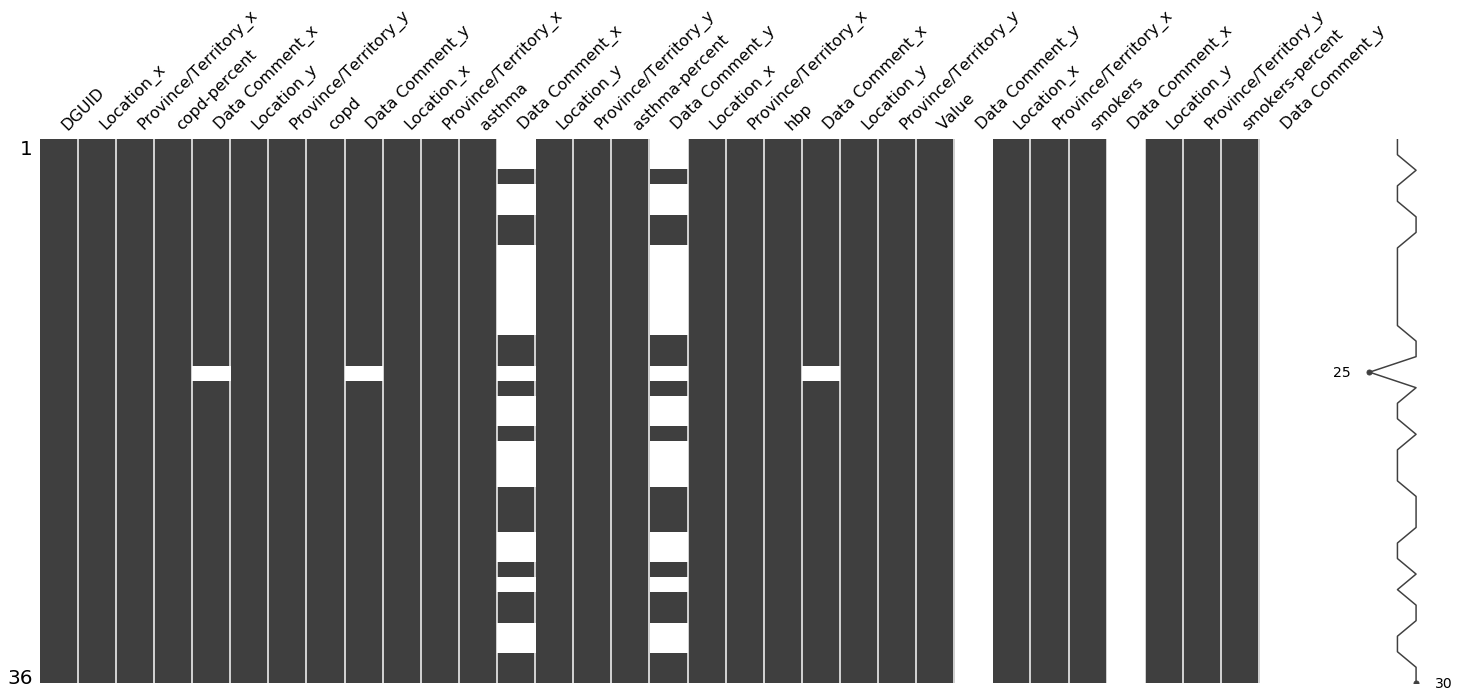

In [9]:
msno.matrix(como2)

In [10]:
como3 = como2.dropna(axis = 'columns').drop(columns = ['Location_y', 'Province/Territory_y',
                                                      'Province/Territory_x'])

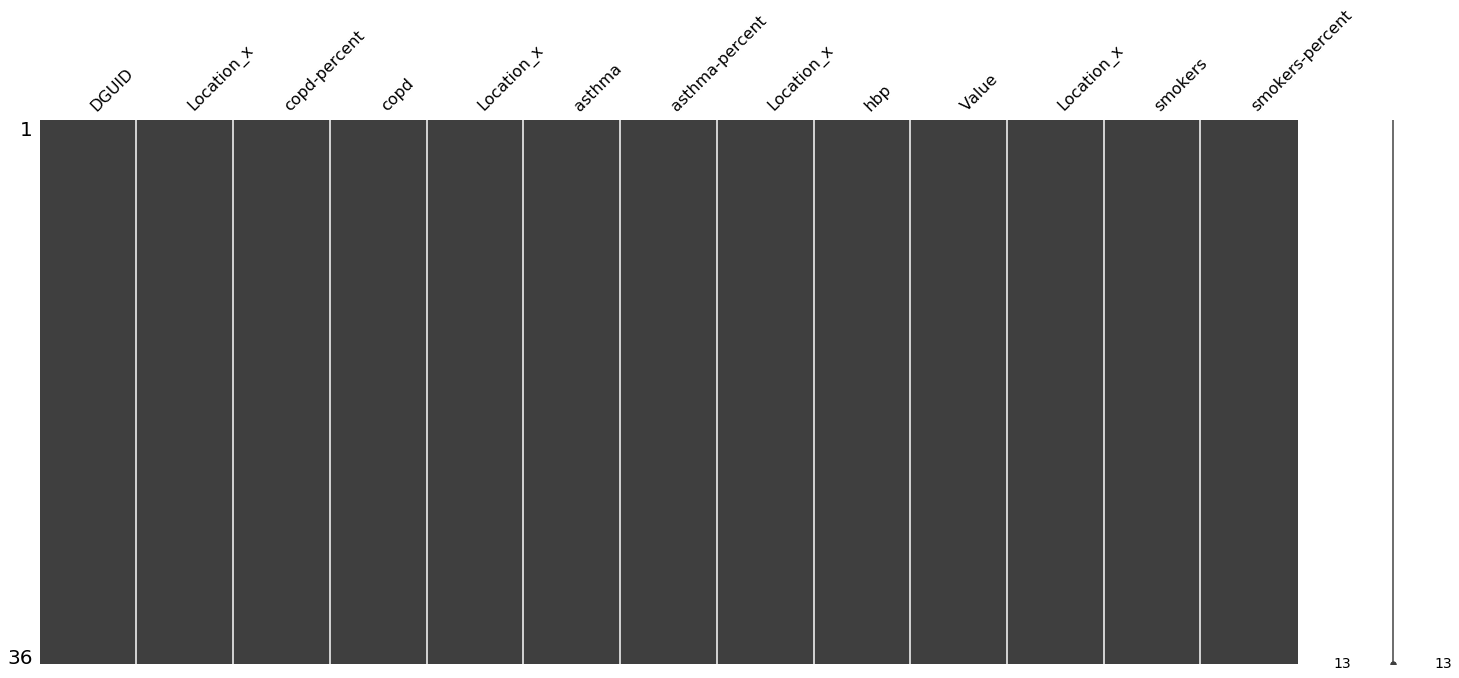

In [11]:
msno.matrix(como3)

---
### Merge with COVID data
---

In [12]:
covid = pd.read_csv('../ON_cases.csv')

In [13]:
# remove duplicated column names
como3 = como3.loc[:,~como3.columns.duplicated()]

# rename location to fit covid data
como3.rename(columns = {'Location_x' :'Reporting_PHU'}, inplace = True)


#### re-organize covid data

In [14]:
covid.Client_Gender.unique()

array(['FEMALE', 'MALE', 'UNKNOWN', 'TRANSGENDER', 'OTHER'], dtype=object)

In [15]:
def contact(x):
    if x == 'Contact of a confirmed case':
        return 1
    else:
        return 0

def neither(x):
    if x == 'Neither':
        return 1
    else:
        return 0

def travel(x):
    if x == 'Travel-Related':
        return 1
    else:
        return 0



In [16]:
covid['CONTACT'] = covid.Case_AcquisitionInfo.map(lambda x: contact(x))
covid['NEITHER'] = covid.Case_AcquisitionInfo.map(lambda x: neither(x))
covid['TRAVEL-RELATED'] = covid.Case_AcquisitionInfo.map(lambda x: travel(x))

In [17]:
def not_resolved(x):
    if x == 'Not Resolved':
        return 1
    else:
        return 0
    
def resolved(x):
    if x == 'Resolved':
        return 1
    else:
        return 0
        
def fatal(x):
    if x == 'Fatal':
        return 1
    else:
        return 0
        

In [18]:
covid['NOT-RESOLVED'] = covid.Outcome1.map(lambda x: not_resolved(x))
covid['RESOLVED'] = covid.Outcome1.map(lambda x: resolved(x))
covid['FATAL'] = covid.Outcome1.map(lambda x: fatal(x))

In [19]:
# covid.groupby('Reporting_PHU').count()

In [20]:
def female(x):
    if x == "FEMALE":
        return 1
    else:
        return 0
    
def male(x):
    if x == "MALE":
        return 1
    else:
        return 0
    
def transgender(x):
    if x == "TRANSGENDER":
        return 1
    else:
        return 0
    
def unknown(x):
    if x == "UNKNOWN":
        return 1
    else:
        return 0
    
def other(x):
    if x == "OTHER":
        return 1
    else:
        return 0

In [21]:
covid['FEMALE'] = covid.Client_Gender.map(lambda x: female(x))
covid['MALE'] = covid.Client_Gender.map(lambda x: male(x))
covid['TRANSGENDER'] = covid.Client_Gender.map(lambda x: transgender(x))
covid['UNKNOWN'] = covid.Client_Gender.map(lambda x: unknown(x))
covid['OTHER'] = covid.Client_Gender.map(lambda x: other(x))

In [22]:
covid2 = covid.groupby('Reporting_PHU')['FEMALE', 'MALE', 'TRANSGENDER', 'UNKNOWN', 'OTHER',
                               'CONTACT', 'NEITHER', 'TRAVEL-RELATED',
                              'NOT-RESOLVED', 'RESOLVED', 'FATAL'].sum()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [23]:
covid2['TOTAL'] = covid.groupby('Reporting_PHU').size().to_list()

---
### Merge with comorbidities
---

**Note:** There are 36 PHUs but only 34 reported in the live-updating Ontario Covid Case data. There are 36 "Health Regions" (as indicated on Statistics Canada exports) in the proximity and comorbidity data. After research, 2 pairs of Health Regions seemed to have merged, reducing the total number of unique regions to 34.

It also appears that some Health Regions were renamed to Public Health Units.

In [24]:
# difference between covid PHU and comorbidities HR
list(set(covid['Reporting_PHU'].unique()) - set(como3['Reporting_PHU'].unique()))

['York Region Public Health Services',
 'Toronto Public Health',
 'Algoma Public Health Unit',
 'Hamilton Public Health Services',
 'Peterborough Public Health',
 'Lambton Public Health',
 'Niagara Region Public Health Department',
 'Halton Region Health Department',
 'Sudbury & District Health Unit',
 'Wellington-Dufferin-Guelph Public Health',
 'Durham Region Health Department',
 'Southwestern Public Health',
 'Peel Public Health',
 'Eastern Ontario Health Unit',
 'Kingston, Frontenac and Lennox & Addington Public Health',
 'Region of Waterloo, Public Health',
 'Ottawa Public Health',
 'Huron Perth District Health Unit']

In [25]:
# rename comorbidities HRs to match ontario covid PHU names
como3.Reporting_PHU.replace({'York Regional Health Unit' : 'York Region Public Health Services',
              'Waterloo Health Unit' : 'Region of Waterloo, Public Health',
            'Halton Regional Health Unit' : 'Halton Region Health Department',
              'Lambton Health Unit' : 'Lambton Public Health',
             'Durham Regional Health Unit' : 'Durham Region Health Department',  
             'City of Ottawa Health Unit' : 'Ottawa Public Health', 
             'Peel Regional Health Unit': 'Peel Public Health',
              'Wellington-Dufferin-Guelph Health Unit': 'Wellington-Dufferin-Guelph Public Health',
            'Kingston, Frontenac and Lennox and Addington Health Unit' : 'Kingston, Frontenac and Lennox & Addington Public Health',
             'The Eastern Ontario Health Unit':'Eastern Ontario Health Unit',
              'City of Hamilton Health Unit':'Hamilton Public Health Services',
              'Niagara Regional Area Health Unit':'Niagara Region Public Health Department',
              'Sudbury and District Health Unit':'Sudbury & District Health Unit',
             'The District of Algoma Health Unit':'Algoma Public Health Unit',
             'Peterborough County - City Health Unit':'Peterborough Public Health',
             'City of Toronto Health Unit' : 'Toronto Public Health'}, inplace = True)

In [26]:
# difference between covid PHU and comorbidities HR - PHU not in HRs
list(set(covid['Reporting_PHU'].unique()) - set(como3['Reporting_PHU'].unique()))

['Southwestern Public Health', 'Huron Perth District Health Unit']

In [27]:
# HRs not in PHU
list(set(como3['Reporting_PHU'].unique()) - set(covid['Reporting_PHU'].unique()))

['Oxford County Health Unit',
 'Huron County Health Unit',
 'Perth District Health Unit',
 'Elgin-St. Thomas Health Unit']

***After Google Search:***

Comorbidities HR | Covid PHU
---------------------|----------
Perth District Health Unit | renamed to Huron Perth 
Huron County Health Unit | renamed to Huron Perth 
Elgin-St. Thomas Health Unit | renamed to Southwestern Public Health
Oxford County Health Unit | renamed to Southwestern Public Health
*Huron County Health Unit has same address as [Huron Perth District Health Unit](https://www.hpph.ca/en/about-us/contact-and-locations.aspx) (77722B London Rd RR 5, Clinton, ON N0M 1L0)

In [28]:
como3.Reporting_PHU.replace({'Perth District Health Unit' : 'Huron Perth District Health Unit',
                             'Huron County Health Unit' : 'Huron Perth District Health Unit',
                            'Elgin-St. Thomas Health Unit' : 'Southwestern Public Health',
                            'Oxford County Health Unit' : 'Southwestern Public Health'}, inplace = True)

In [29]:
covidmerge = pd.merge(como3, covid2, how = 'inner', on = 'Reporting_PHU')
covidmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DGUID            36 non-null     object
 1   Reporting_PHU    36 non-null     object
 2   copd-percent     36 non-null     object
 3   copd             36 non-null     object
 4   asthma           36 non-null     object
 5   asthma-percent   36 non-null     object
 6   hbp              36 non-null     object
 7   Value            36 non-null     object
 8   smokers          36 non-null     object
 9   smokers-percent  36 non-null     object
 10  FEMALE           36 non-null     int64 
 11  MALE             36 non-null     int64 
 12  TRANSGENDER      36 non-null     int64 
 13  UNKNOWN          36 non-null     int64 
 14  OTHER            36 non-null     int64 
 15  CONTACT          36 non-null     int64 
 16  NEITHER          36 non-null     int64 
 17  TRAVEL-RELATED   36 non-null     int6

In [30]:
covidmerge.to_csv('../covid_comorbidities.csv')